In [6]:
import qtensor
import xarray as xar
import numpy as np
import matplotlib.pyplot as plt
import pickle
import sys
sys.path.append('../data/generators/')
import miplog_helper
import pandas as pd

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
def to_mh(item) -> miplog_helper.MiplogData:
    starts, *diffs = item
    return miplog_helper.MiplogData.from_start_and_diffs(starts, diffs)

#a# Gurobi performance for different approximation ratio
### Read data

In [7]:
data_match = pickle.load(open('../data/gurobi_match.pkl', 'rb'))
data_opt = xar.open_dataarray('../data/gurobi_opt_threads1.nc')
quantum_data = xar.open_dataarray('../data/quantum_nsamples1000_d3.nc')
mip_data = pd.read_csv('../data/message_passing_data.csv')

In [8]:
data_match.coords

Coordinates:
  * N        (N) int64 30 100 150 432 716 ... 33750 40000 50000 75000 100000
  * seed     (seed) int64 10 11 12 13 14 15 16 17 18 ... 72 73 74 75 76 77 78 79

In [9]:
data_opt.coords

Coordinates:
  * N        (N) int32 10 26 42 58 74 90 106 122 ... 346 362 378 394 410 426 442
  * seeds    (seeds) int32 10 11 12 13 14

In [10]:
quantum_data.coords

Coordinates:
  * N        (N) int32 30 100 150 432 716 ... 33750 40000 50000 75000 100000
  * p        (p) int32 3 6 8 12 14 16 18 20 32
  * types    (types) object 'transport' 'destructive'

In [11]:
mip_data

,N=100 cut fraction,N=100 time to solution (s),N=500 cut fraction,N=500 time to solution (s),N=1000 cut fraction,N=1000 time to solution (s),N=5000 cut fraction,N=5000 time to solution (s),N=10000 cut fraction,N=10000 time to solution (s),N=50000 cut fraction,N=50000 time to solution (s),N=100000 cut fraction,N=100000 time to solution (s)
0,0.840000,0.000997,0.850667,0.003207,0.845333,0.006971,0.852133,0.033910,0.846800,0.073807,0.847760,0.334345,0.847020,0.736691
1,0.853333,0.000998,0.846667,0.002988,0.850000,0.007153,0.850533,0.034907,0.845733,0.072740,0.847053,0.339247,0.848353,0.741219
2,0.853333,0.000000,0.848000,0.003063,0.848667,0.006200,0.848533,0.033910,0.846733,0.071540,0.848907,0.340011,0.846580,0.730526
3,0.820000,0.000998,0.854667,0.003989,0.840000,0.006202,0.847467,0.034907,0.847600,0.071392,0.847547,0.338106,0.847440,0.747059
4,0.880000,0.001096,0.842667,0.003038,0.853333,0.006202,0.854533,0.034907,0.850733,0.080796,0.846080,0.332975,0.847740,0.720049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.880000,0.000999,0.853333,0.003982,0.844000,0.006981,0.846400,0.036837,0.847667,0.066844,0.847253,0.348867,0.848113,0.671874
996,0.820000,0.001173,0.848000,0.003989,0.854667,0.006982,0.847467,0.035459,0.847533,0.067851,0.847293,0.350518,0.848887,0.685660
997,0.860000,0.001040,0.849333,0.004198,0.846667,0.006981,0.849200,0.035961,0.846467,0.065869,0.847427,0.371095,0.847647,0.680797
998,0.826667,0.000000,0.853333,0.002996,0.859333,0.006981,0.844933,0.035900,0.847600,0.066927,0.847347,0.345431,0.847820,0.671201


In [43]:
# transform MP data
timecol = lambda x: f'N={x} time to solution (s)'
cutcol = lambda x: f'N={x} cut fraction'
mip_ns = 100, 500, 1000, 5000, 10000, 50000, int(1e5)

data_tr = []
for N in mip_ns:
    data_tr.append([
        mip_data[timecol(N)],
        mip_data[cutcol(N)]
    ])
mip_data_xar = xar.DataArray(data=data_tr, dims=['N', 'kind', 'seed'], coords=dict(
    kind=['time', 'cut'],
    N=list(mip_ns),
    seed=list(range(len(mip_data)))
))
mip_data_xar.coords

Coordinates:
  * kind     (kind) <U4 'time' 'cut'
  * N        (N) int64 100 500 1000 5000 10000 50000 100000
  * seed     (seed) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999

In [21]:
def get_colors(n, cm=plt.cm.gnuplot2, offset=0.2):
    return [cm(offset + x*(1-2*offset)) for x in np.linspace(0, 1, n)]

In [22]:
def approx_ratio(p):
    ps = [qtensor.tools.BETHE_QAOA_VALUES[str(p)]['val'] for p in range(1, 12)]
    try:
        AR = ps[p-1]
        if AR>0:
            return AR
        else:
            raise KeyError
    except (KeyError, IndexError):
        last_2 = ps[-2:]
        dif = last_2[1] - last_2[0]
        dif *= .7
        AR = last_2[1] + dif*(p-11)
    
    return AR

def get_data_AR_lower(data, AR, nan_repl=None):
    times =  xar.apply_ufunc(lambda x: to_mh(x).get_time_for_AR_lower(AR)[0], data, vectorize=True)
    ftimes = times.astype(np.float)
    ftimes.data[np.isnan(ftimes.data)] = nan_repl or np.nan
    return ftimes

def get_data_AR_upper(data, AR, nan_repl=None):
    times =  xar.apply_ufunc(lambda x: to_mh(x).get_time_for_AR_upper(AR)[0], data, vectorize=True)
    ftimes = times.astype(np.float)
    ftimes.data[np.isnan(ftimes.data)] = nan_repl or np.nan
    return ftimes

## Approx ratio extrapolation

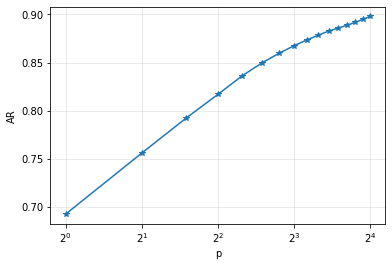

In [23]:
ps = range(1, 17)
ars = [approx_ratio(p) for p in ps]


plt.plot(np.array(ps), ars, '*-')
plt.xscale('log', base=2)
plt.xlabel('p')
plt.ylabel('AR')
plt.grid(alpha=.3)

In [24]:
approx_ratio(40)

0.9704369617251701

## Gurobi zero-time quality

In [25]:
def datapoint_at_time(lst, time=0):
    mh = to_mh(lst)
    miplog = mh.miplog
    for t, ub, lb in miplog:
        if t>time:
            if lb > 0:
                return dict(time=t, ub=ub, lb=lb)
    return dict(time=t, ub=ub, lb=lb)

In [26]:
def plot_with_statband(x, y, perc=.8, *args, **kwargs):
    mn = np.median(y, -1)
    thresh = 100*(1-perc)/2
    up = np.percentile(y, 100-thresh, -1)
    dn = np.percentile(y, thresh, -1)
    plt.plot(x, mn, *args, **kwargs)
    color = kwargs.get('color')
    plt.fill_between(x, up, dn, alpha=.1, color=color)

In [27]:
from functools import partial

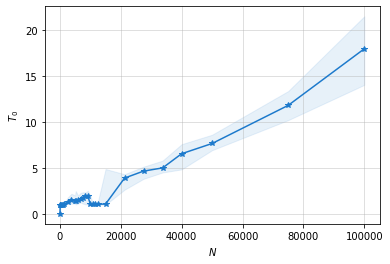

In [73]:
first_dps = xar.apply_ufunc(datapoint_at_time, data_match, vectorize=True)
minutes = 60
T = 10*minutes
t_dps = xar.apply_ufunc(partial(datapoint_at_time, time=T), data_match, vectorize=True)
tms = xar.apply_ufunc(lambda x: x['time'], first_dps, vectorize=True)
tms_t = xar.apply_ufunc(lambda x: x['time'], t_dps, vectorize=True)
lbs = xar.apply_ufunc(lambda x: x['lb'], first_dps, vectorize=True)

color = '#1d7acc'
plt.ylabel('$T_0$')
plt.xlabel('$N$')
plot_with_statband(first_dps.N, tms, .8, '*-', color=color)
#plot_with_statband(t_dps.N, tms_t, .8, '*-', color=color)
#plt.plot(first_dps.N, tms.median('seed'), '*-')
plt.grid(alpha=.5)
plt.savefig('./pdf/t0_gurobi_default.pdf')

In [33]:
mip_data_xar.coords

Coordinates:
    *empty*

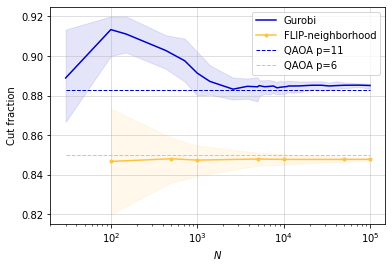

In [76]:
#plt.title('Cut fraction at $T_0$ for Gurobi')

plt.ylabel('Cut fraction')
plt.xlabel('$N$')
colors = get_colors(2)

# Gurobi data
plot_with_statband(first_dps.N, lbs/first_dps.N/1.5,
                   color=colors[0],
                   label='Gurobi'
                  )

# Message Passing data
plot_with_statband(mip_data_xar.N, mip_data_xar.sel(kind='cut'),
                   color=colors[1],
                   marker='.',
                   label='FLIP-neighborhood'
                  )

# QAOA data
ps = [6, 11]
colors = iter(get_colors(len(ps)))
for p in reversed(ps):
    linestyle = '--'
    if p>11:
        linestyle = '--'
    plt.hlines(approx_ratio(p), min(first_dps.N), max(first_dps.N),
               label=f'QAOA p={p}', color=next(colors), linewidth=1, 
               linestyle=linestyle
              )
plt.legend(
    #title='MaxCut performance',
)
plt.grid(alpha=.5)
plt.xscale('log')
plt.savefig('pdf/t0_cut_gurobi_default.pdf')

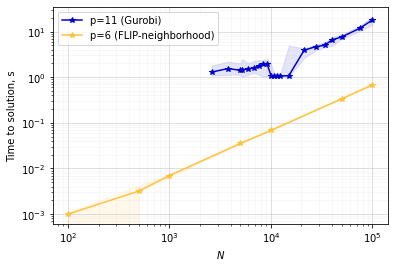

In [75]:
#plt.title('Sample rate of quantum device to overperform Gurobi.\np=12')

plt.xlabel('$N$')
plt.ylabel('Time to solution, s')
color = '#1d7acc'
TH = 2500
colors = get_colors(2)
matched_quality = first_dps.N > TH

# Gurobi data
plot_with_statband(first_dps.N[matched_quality], tms[matched_quality], .8, '*-',
                   color=colors[0],
                   label='p=11 (Gurobi)'
                  )

# Message passing data
plot_with_statband(mip_data_xar.N, mip_data_xar.sel(kind='time'), .8, '*-',
                   color=colors[1],
                   label='p=6 (FLIP-neighborhood)'
                  )

plt.grid(alpha=.5)
ps = [6, 11, 12, 14]
plt.grid(which='major', alpha=.5)
plt.grid(which='minor', alpha=.1)
plt.xscale('log')
#plt.xlim(700, 1e5+20000)

"""
color='red'
ylimm = 0.5*(ylimx+ylimy)
plt.arrow(TH, ylimm, -1000, 0, width=0.01, head_length=200, edgecolor=color, color=color)
ylimx, ylimy = plt.ylim()
plt.vlines(TH, 0, ylimy, color=color)
plt.text(TH-100, ylimm+0.05, 'No advantage\nhere', horizontalalignment='right', color='darkred')
"""

plt.yscale('log')
plt.legend()

plt.savefig('pdf/advantage_sampling_freq.pdf')

## Gurobi cut fraciton

In [18]:
def get_opt_gap(mh, ts):
    up, low = mh.get_bounds_at(ts)
    return (up-low)/low

def get_lb(mh, ts):
    up, low = mh.get_bounds_at(ts)
    if (up is None) or (low is None):
        return None
    return low/up

def get_ub(mh, ts):
    up, low = mh.get_bounds_at(ts)
    up, low2 = mh.get_bounds_at(np.inf)
    return low/low2

def get_cut_frac(mh, ts, N):
    no_edges = 1.5*N
    up, low = mh.get_bounds_at(ts)
    if (low is None):
        return None
    return  low/no_edges

def get_cut_frac_ub(mh, ts, N):
    no_edges = 1.5*N
    up, low = mh.get_bounds_at(ts)
    if (low is None):
        return None
    return  up/no_edges

In [19]:
def quantum_lower_bound(AR, N_samples, conf=.5):
    return (1-(1-AR)*(1-conf)**(-1/N_samples))


In [20]:
data_match_mh = xar.apply_ufunc(to_mh, data_match, vectorize=True)
len(data_match_mh.seed)

70

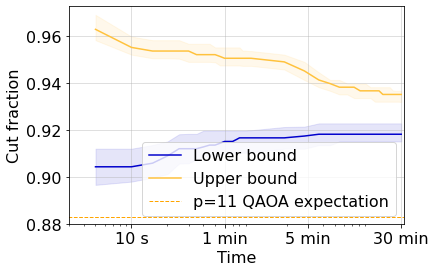

In [78]:
N_samples = 20    
select_p = [20, 14, 12]
select_N = [432]
p = 11
AR = approx_ratio(p=p)

nfigs = len(select_N)

times = np.concatenate([
    np.linspace(5, 100, 20)
    , np.linspace(100, 1800, 20)
])

fig, axs = plt.subplots(1, nfigs, figsize=(6*nfigs, 4), sharey='row')
for i in range(nfigs):
    # -- Handle axes: case where 1 axis and many
    N = select_N[i]
    try: 
        ax = axs[i] # only for single row layout
    except:
        ax = axs
    plt.sca(ax)
    # --
   
    # -- Handle gurobi match
    colors = iter(get_colors(2))
    # ---- Calculate lower bound for various times
    # ------ Lower bound
    gaps = []
    for ts in times:
        at_time = []
        for x in data_match_mh.sel(N=N):
            mh = x.item()
            value = get_cut_frac(mh, ts, N)
            at_time.append(value)
        gaps.append(at_time)
    # ----
    
    gaps = np.array(gaps).astype(np.float)
    plot_with_statband(times, gaps, label='Lower bound', color=next(colors))
    # ------ Upper bound
    gaps = []
    for ts in times:
        at_time = []
        for x in data_match_mh.sel(N=N):
            mh = x.item()
            value = get_cut_frac_ub(mh, ts, N)
            at_time.append(value)
        gaps.append(at_time)
    
    gaps = np.array(gaps).astype(np.float)
    plot_with_statband(times, gaps, label='Upper bound', color=next(colors))
    # --
    
    ylim = plt.gca().get_ylim()
    
    xlim = plt.gca().get_xlim()
    plt.xscale('log')
    plt.hlines(AR, xlim[0], xlim[1], linestyle='--', color='orange', linewidth=1, 
               label=f'p={p} QAOA expectation'
              )
    
    plt.xlim(*[3, max(*xlim)])
    plt.ylim(0.88, ylim[1]*1.0)
    plt.grid(alpha=0.5)
    
    
    # -- Ticks prettify
    ticks = list(plt.gca().get_xticks())[1:-1]
    ticks = [0, 10, 60, 300, 30*60 , 0]
    def get_label(x):
        if x>=60*60:
            return f'{round(x/60/60)} h'
        if x>=60:
            return f'{round(x/60)} min'
        elif x>1:
            return f'{round(x)} s'
        elif x>0.001:
            return f'{round(x*1000)} ms'
    
    labels = [get_label(x) if x!=0 else '0' for x in ticks]
    plt.xticks(ticks=ticks[1:-1], labels=labels[1:-1])
    # --
    plt.legend()
    plt.ylabel('Cut fraction')
    plt.xlabel('Time')

plt.savefig('./pdf/gurobi_timebounds.pdf')

N_sampl 20
p 12
0.8818380068471259
red q 5.498980000000001
0.8818380068471259
av [0.8848     0.8865     0.8865     0.8865     0.8865     0.88696667
 0.887      0.887      0.88703333 0.88723333 0.8877     0.88806667
 0.89033333 0.89356667 0.9007     0.9063     0.90843333 0.90943333
 0.90973333 0.91013333 0.91013333 0.91173333 0.91193333 0.91193333
 0.91193333 0.91193333 0.91193333 0.91193333 0.91193333 0.91193333
 0.91193333 0.91193333 0.91193333 0.91193333 0.91193333 0.91193333
 0.91193333 0.91193333 0.91193333 0.91193333]
N=10000.0 best gap is 0.9119333333333334
[0.0, 250.0, 500.0, 750.0, 1000.0, 1250.0, 1500.0, 1750.0]
N_sampl 20
p 12
0.8818380068471259
red q 11.573979999999999
0.8818380068471259
av [0.88495686 0.88599216 0.88825098 0.89592157 0.90238431 0.90465882
 0.90577255 0.90707451 0.90826667 0.9088     0.90922353 0.90939608
 0.90944314 0.90947451 0.90950588 0.90969412 0.90997647 0.91002353
 0.91003922 0.91024314 0.91024314 0.91152941 0.91195294 0.91215686
 0.91250196 0.9127529

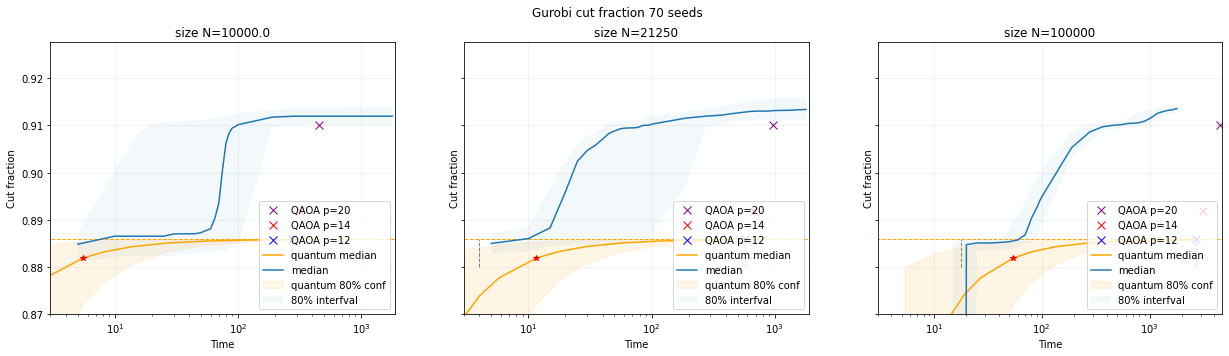

In [22]:
N_samples = 20    
select_p = [20, 14, 12]
select_N = [1e4, 21250, 100000]

nfigs = len(select_N)

times = np.concatenate([
    np.linspace(5, 100, 20)
    , np.linspace(100, 1800, 20)
])

fig, axs = plt.subplots(1, nfigs, figsize=(7*nfigs, 5), sharey='row')
for i in range(nfigs):
    # -- Handle axes: case where 1 axis and many
    N = select_N[i]
    try: 
        ax = axs[i] # only for single row layout
    except:
        ax = axs
    plt.sca(ax)
    # --
    

    # -- Plot quantum guarantees for 1000 iterations
    colors=iter(['purple', 'red', 'blue'])
    for p in select_p:
        AR = approx_ratio(p)
        quants = quantum_data.sel(p=p, types='transport')
        time_q = quants[np.abs(quants.N - N).argmin()].data.item()
        plt.plot(time_q, AR, 'x', label=f'QAOA p={p}', color=next(colors), markersize=8)
    # --
        
    # -- Demonstrate special case for the _last_ p
    p = p
    time_q = time_q
    AR = approx_ratio(p)
    print('N_sampl', N_samples)
    print('p', p)
    
    q_reps = [2, 3, 4, 5, 7, 10, 20, 30, 50, 100, 200, 500, 1000]
    q_times = [time_q*x/1000 for x in q_reps]
    p_fail = 0.5
    ksi_min = [1-(1-AR)*(p_fail)**(-1/N) for N in q_reps]
    plt.plot(q_times, ksi_min, color='orange', label='quantum median')
    print(quantum_lower_bound(AR, N_samples, p_fail))
    plt.plot(time_q*N_samples/1000, quantum_lower_bound(AR, N_samples, p_fail), '*', color='red')
    print('red q', time_q/1000*N_samples)
    
    conf = 0.1
    ksi_min_low = [1-(1-AR)*(conf)**(-1/N) for N in q_reps]
    ksi_min_up = [1-(1-AR)*(1-conf)**(-1/N) for N in q_reps]
    plt.fill_between(q_times, ksi_min_low, ksi_min_up, alpha=0.1,
                     color='orange', label='quantum 80% conf')
    # --
    
    # -- calculate Classical match time
    times_ar = []
    AR_adj = quantum_lower_bound(AR, N_samples, p_fail)
    print(AR_adj)
    for seed in data_match_mh.seed:
        mh = data_match_mh.sel(seed=seed, N=N).data.item()
        t, _ = mh.get_time_for_AR_lower(AR_adj)
        if t is None:
            t=np.inf
        times_ar.append(t)
    time_g = np.median(times_ar)
    # --
    
    # -- Nice vertical lines
    plt.vlines(time_g, 0.88, AR, linestyle='--', color='gray', linewidth=1)
    plt.vlines(time_q, 0.88, AR, linestyle='--', color='gray', linewidth=1)
        
    
    # -- Handle gurobi match
    # ---- Calculate lower bound for various times
    gaps = []
    for ts in times:
        at_time = []
        for x in data_match_mh.sel(N=N):
            mh = x.item()
            value = get_cut_frac(mh, ts, N)
            at_time.append(value)
        gaps.append(at_time)
    # ----
    
    gaps = np.array(gaps).astype(np.float)
    av = np.nanmedian(gaps, -1)
    print('av', av)
    plt.plot(times, av, '-', label=f'median')


    shift = 10
    up = np.percentile(gaps, 100-shift, axis=-1)
    dn = np.percentile(gaps, shift, axis=-1)
    plt.fill_between(times, dn, up, alpha=0.05, label=f'{100-2*shift}% interfval')
    # --

    plt.grid(alpha=.2, zorder=0)
    print(f'N={N} best gap is {av[-1]}')
    plt.title(f'size N={N}')
    
    
    # -- Ticks prettify
    num_ticks = list(plt.gca().get_xticks())[1:-1]
    print(num_ticks)
    ticks = num_ticks + [time_g, time_q]
    def get_label(x):
        if x>60*60:
            return f'{round(x/60/60)} h'
        if x>60:
            return f'{round(x/60)} min'
        elif x>1:
            return f'{round(x)} s'
        elif x>0.001:
            return f'{round(x*1000)} ms'
    
    num_labels = [get_label(x) if x!=0 else '0' for x in num_ticks]
    labels = num_labels + [r'$\tau_C$', r'$\tau_Q$']
    plt.xticks(ticks=ticks, labels=labels)
    ticks_large = plt.xticks()[-1][-2:]
    for tick in ticks_large:
        tick.set_fontsize(14)
    # --
    
    ylim = plt.gca().get_ylim()
    
    xlim = plt.gca().get_xlim()
    plt.xscale('log')
    plt.hlines(AR, xlim[0], xlim[1], linestyle='--', color='orange', linewidth=1)
    
    plt.xlim(*[3, max(*xlim)])
    plt.ylim(0.87, ylim[1]*1.0)

    plt.legend(loc='lower right')
    plt.xlabel('Time')
    plt.ylabel('Cut fraction')
plt.suptitle(f'Gurobi cut fraction {len(data_match_mh.seed)} seeds')
plt.savefig(f'./pdf/bound_vs_time_N{N}.pdf')

In [23]:
mh = to_mh(data_match.sel(N=1000, seed=10).item())

In [24]:
data_match.coords

Coordinates:
  * N        (N) int64 30 100 150 432 716 ... 33750 40000 50000 75000 100000
  * seed     (seed) int64 10 11 12 13 14 15 16 17 18 ... 72 73 74 75 76 77 78 79

## QAOA bounds

In [25]:
import sys
import os
import networkx as nx
import itertools
import scipy
import matplotlib
matplotlib.rcParams.update({'font.size':16})

# Expectation values of various 1-loop subgraphs
# from E:\JONATHAN\Documents\POSTDOC\Bethe_lattice_optimization\little_loop_evaluator.py
with open('../data/single_loop_graphs_eval.json', 'r') as f:
    payload = json.load(f)

with open('../data/3r_optimization_and_fixed.json', 'r') as f:
    payload_ensemble = json.load(f)

# Compute average cut fractions for the ensemble of graphs...
ensemble_average = {q:[] for q in range(4,17,2)}
for yolk in payload_ensemble:
    nn = np.array(yolk['edges']).max() + 1
    inddat = [yolk['fixed_value_p='+str(q)] for q in range(1,7)]
    ensemble_average[nn].append(inddat)

ensemble_average = np.array([np.average(np.array(ensemble_average[q]),0)/(q*1.5) for q in range(4,17,2)])

In [26]:
def prob_L(l, N, connectivity = 3):
    '''
    Computes an upper bound on the probability that an edge participates
    in a cycle of length l
    l - cycle length
    N - number of edges in the graph
    connectivity - edges per vertex
    '''
    lambL = (connectivity - 1)**l / (2*l)
    val = lambL*l*(1 - np.exp(-lambL))
    return np.minimum(1, val/N)

In [38]:
import xarray
qaoa_heuristic_data = xarray.load_dataarray('../../../gamma_beta_paper/fixed-angle-QAOA/data/QAOA_cost_vs_N.nc')
qaoa_heuristic_data.coords

Coordinates:
  * seed     (seed) int32 10 11 12 13 14 15 16 17 18 ... 34 35 36 37 38 39 40 41
  * N        (N) int32 8 16 32 64 128 256
  * p        (p) int32 1 2 3 4

<ipython-input-76-4f7dbe024f04>:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C5--" (-> color=(0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)). The keyword argument will take precedence.
  plt.semilogx(N, Cmin, 'C'+str(p-1)+'--', label='p='+str(p), color=color, zorder=p)
<ipython-input-76-4f7dbe024f04>:41: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C5:" (-> color=(0.5490196078431373, 0.33725490196078434, 0.29411764705882354, 1.0)). The keyword argument will take precedence.
  plt.semilogx(N, Cmax, 'C'+str(p-1)+':', color=color, zorder=p)
<ipython-input-76-4f7dbe024f04>:37: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C3--" (-> color=(0.8392156862745098, 0.15294117647058825, 0.1568627450980392, 1.0)). The keyword argument will take precedence.
  plt.semilogx(N, Cmin, 'C'+str(p-1)+'--', label='p='+str(p), color=color, 

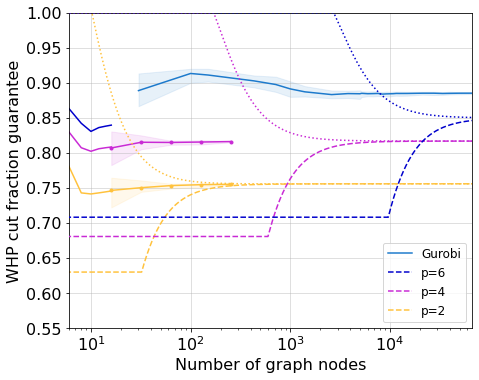

In [76]:
plt.figure(figsize=(8, 6))
plt.subplots_adjust(left=0.15, right=0.85, bottom=0.15)
ax = plt.subplot(1,1,1)

Cbounds = []
ps = list(reversed(range(2, 7, 2)))
colors = iter(get_colors(len(ps)))

# -- gurobi
color = '#1d7acc'
plt.ylabel('Cut fraction')
plt.xlabel('$N$')
plot_with_statband(first_dps.N, lbs/first_dps.N/1.5, color=color, label='Gurobi')
plt.grid(alpha=.5)
plt.xscale('log')
plt.savefig('pdf/t0_cut_gurobi_default.pdf')
# --

for i, p in enumerate(ps):
    N = np.logspace(np.log10(4),5,5001)
    
    probs = np.array([prob_L(q, N) for q in range(3,2*p+2)])
    
    P_none = np.product(1-probs,0)
    #P_one = (probs/(1-probs))*P_none
    P_one = np.array([np.product(1-probs[0:q,:],0)*np.product(1-probs[q::,:],0)*probs[q,:] for q in range(probs.shape[0])])
    
    notP = 1 - P_none - P_one.sum(0)
    
    Cmin = P_none*payload[str(p)][0] + np.dot(P_one.T,payload[str(p)][1::])
    Cmin = np.maximum(5/6*payload[str(p)][0], Cmin)
    color = next(colors)
    
    # Convert number of edges to number of nodes
    N = N/1.5
    
    plt.semilogx(N, Cmin, 'C'+str(p-1)+'--', label='p='+str(p), color=color, zorder=p)
    
    Cmax = P_none*payload[str(p)][0] + np.dot(P_one.T,payload[str(p)][1::]) + notP
    Cmax = np.minimum(1, Cmax)
    plt.semilogx(N, Cmax, 'C'+str(p-1)+':', color=color, zorder=p)
    
    Cbounds.append([Cmin,Cmax])
    
    plt.plot(np.arange(6,17,2), ensemble_average[1:, p-1], '-', color=color)
    if p<5:
        y_ = qaoa_heuristic_data.sel(p=p)[1:]
        x_ = qaoa_heuristic_data.N[1:]
        y_ = y_.fillna(y_.mean('seed'))
        plot_with_statband(x_, y_/1.5/x_, color=color, marker='.')

plt.axis([6,max(N),0.55,1])
plt.legend(loc=4,fontsize=12).set_zorder(100)
plt.xlabel('Number of graph nodes')
plt.ylabel('WHP cut fraction guarantee')
plt.savefig('./pdf/pp_cut_fraction_bounds.pdf')

Text(0, 0.5, 'WHP cut fraction guarantee')

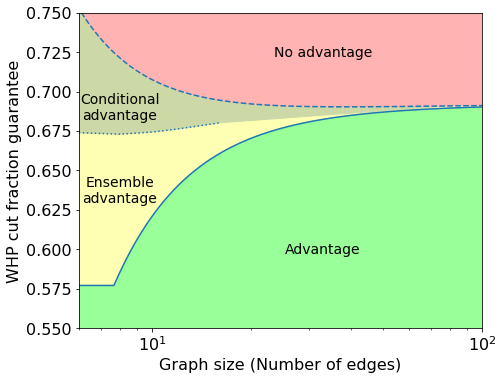

In [28]:
plt.figure(figsize=(8,6))
plt.subplots_adjust(left=0.15,right=0.85,bottom=0.15)
ax = plt.subplot(1,1,1)

plt.semilogx(N,Cbounds[0][0],'C0-')
plt.semilogx(N,Cbounds[0][1],'C0--')
plt.plot(np.arange(6, 17, 2), ensemble_average[1::,0], ':')


Avvals = np.concatenate((ensemble_average[1::,0],[payload['1'][0]]))
AvN    = np.concatenate((np.arange(6,17,2),[100]))
plt.fill_between(AvN,np.zeros(len(AvN)),Avvals,color=[1,1,0.7])
plt.fill_between(AvN,Avvals,np.ones(len(AvN)),color=[0.8,.85,0.65])

plt.fill_between(N,Cbounds[0][1],np.ones(len(N)),color=[1,0.7,0.7])
plt.fill_between(N,np.zeros(len(N)),Cbounds[0][0],color=[0.6,1,0.6])

plt.text(33,0.6,'Advantage',verticalalignment='center',horizontalalignment='center',fontsize=14)
plt.text(8,0.637,'Ensemble\nadvantage',verticalalignment='center',horizontalalignment='center',fontsize=14)
plt.text(8,0.69,'Conditional\nadvantage',verticalalignment='center',horizontalalignment='center',fontsize=14)
plt.text(33,0.725,'No advantage',verticalalignment='center',horizontalalignment='center',fontsize=14)


plt.axis([6,100,0.55,0.75])
plt.xlabel('Graph size (Number of edges)')
plt.ylabel('WHP cut fraction guarantee')

---
---

## Older scripts

In [ ]:
Ps = [6, 12, 24]
colors = iter(get_colors(len(Ps)+1))
for p in Ps:
    AR = approx_ratio(p)
    print('AR is', AR)
    data_p = get_data_AR_lower(data_match, AR, nan_repl=np.inf)
    av = data_p.median('seed')
    std = data_p.std('seed')
    mi = data_p.min('seed')
    mx = data_p.max('seed')
    color = next(colors)
    plt.plot(av.N, av,  '*-', color=color, label=f'p={int(p)}')
    #plt.fill_between(av.N, av+std, av-std, alpha=0.1, color=color)
    up = np.percentile(data_p, 85, axis=-1)
    dn = np.percentile(data_p, 15, axis=-1)
    plt.fill_between(av.N, dn, up, alpha=0.05, color=color)
    
color = next(colors)
plt.plot(data_opt.N, data_opt.mean('seeds'), color=color, label=r'p=$\infty$')
plt.fill_between(data_opt.N,
                 data_opt.min('seeds'),
                 data_opt.max('seeds'),
                 alpha=0.1,
                 color=color)
plt.xlabel('N')
plt.ylabel('time')
#plt.legend(loc='upper right')
plt.legend()
print(f'Average is over {len(data_match.seed)} seeds')
plt.plot(quantum_data.N, quantum_data.sel(p=12, types='transport'), color='red')
plt.grid()
plt.savefig('./pdf/gurobi_match_time_vs_p.pdf')

### Quantum quality vs n samples


Ratio at 20 samples 0.9940675829051888


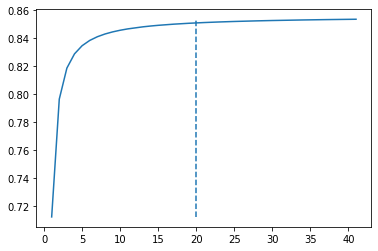

In [193]:
def quantum_lower_bound(AR, N_samples, conf=.5):
    return (1-(1-AR)*(1-conf)**(-1/N_samples))

q_reps = [int(1.1**x) for x in range(1, 40)]
AR = .856
conf = .5
ksi_min_up = [quantum_lower_bound(AR, N, conf=conf) for N in q_reps]
plt.plot(q_reps, ksi_min_up)
select_samples = 20
ratio_select = quantum_lower_bound(AR, select_samples, conf)/AR 
plt.vlines(select_samples, min(ksi_min_up), max(ksi_min_up), linestyle='--')
print(f'Ratio at {select_samples} samples', ratio_select)


### A log-log plot

AR p 6 0.8446001864027964
AR p 12 0.8818380068471259
AR p 14 0.8880920366031804
14.76040232181549
AR p 18 0.9006000961152894
AR p 20 0.9068541258713438
Average is over 50 seeds
<xarray.DataArray ()>
array(13.48756)
Coordinates:
    N        int32 21250
    p        int32 14
    types    <U9 'transport'


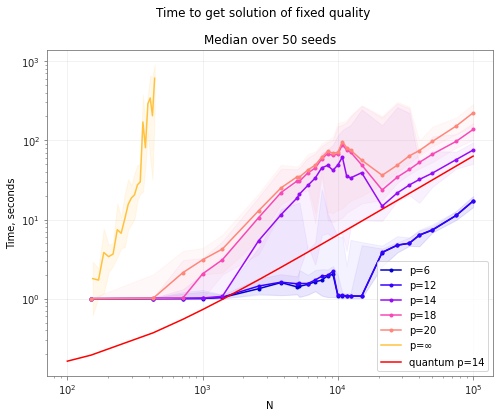

In [202]:
Ps = [6, 12, 14, 18, 20]
N_samples = 20
plt.figure(figsize=(8,6))

colors = iter(get_colors(len(Ps)+1))
for p in Ps:
    AR = approx_ratio(p)
    AR = quantum_lower_bound(AR, N_samples, conf=.5)
    print('AR p', p, AR)
    data_p = get_data_AR_lower(data_match, AR, nan_repl=np.inf)
    if p==14:
        print(np.median(data_p.sel(N=21250)))
    av = data_p.median('seed')
    std = data_p.std('seed')
    mi = data_p.min('seed')
    mx = data_p.max('seed')
    color = next(colors)
    plt.plot(av.N, av.where(av.N>100), '.-', color=color, label=f'p={p}')
    #plt.fill_between(av.N, av+std, av-std, alpha=0.1, color=color)
    #plt.fill_between(av.N, mi, mx, alpha=0.05, color=color)
    up = np.percentile(data_p.where(data_p.N>100), 90, axis=-1)
    dn = np.percentile(data_p.where(data_p.N>100), 10, axis=-1)
    plt.fill_between(av.N, dn, up, alpha=0.05, color=color)
    
color = next(colors)
data_opt_sub = data_opt.where(data_opt.N>10+32*4)
# -- Gurobi optimal
plt.plot(data_opt.N, data_opt_sub.mean('seeds'), color=color, label=r'p=$\infty$')
plt.fill_between(data_opt_sub.N,
                data_opt_sub.min('seeds'),
                data_opt_sub.max('seeds'),
                alpha=0.1,
                color=color)
plt.xlabel('N')
plt.ylabel('Time, seconds')

print(f'Average is over {len(data_match.seed)} seeds')
# -- quantum data
quantum_sub_data = quantum_data.where(quantum_data.N>30)
quantum_sub_data = quantum_sub_data.where(quantum_sub_data.N<=2e5)

p = 14
plt.plot(quantum_sub_data.N,
         quantum_sub_data.sel(p=p, types='transport')/1000*N_samples,
         color='red',
         label=f'quantum p={p}')
Nclose = quantum_sub_data.N[np.abs(quantum_sub_data.N-21250).argmin()]
print(quantum_sub_data.sel(N=Nclose, p=p, types='transport')/1000*N_samples)

#plt.ylim(.8, 1200)
#plt.xlim(100, max(data_match.N)*1.15)
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=.2)
plt.legend()
plt.suptitle('Time to get solution of fixed quality')
plt.title(f'Median over {len(data_match.seed)} seeds')
plt.savefig('./pdf/gurobi_match_time_vs_p_loglog.pdf')

### Upper bound


In [194]:
approx_ratio(55)

1.0157444208017952

/home/plate/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/plate/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')
/home/plate/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1539: RuntimeWarning: invalid value encountered in subtract
  np.subtract(arr, avg, out=arr, casting='unsafe')


Average is over 50 seeds


NameError: name 'N_samples' is not defined

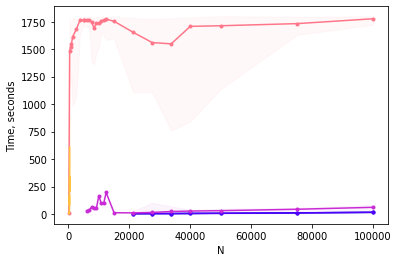

In [195]:
Ps = [ 6, 22, 40, 55]

colors = iter(get_colors(len(Ps)+1))
for p in Ps:
    data_p = get_data_AR_upper(data_match, approx_ratio(p), nan_repl=np.inf)
    av = data_p.median('seed')
    std = data_p.std('seed')
    mi = data_p.min('seed')
    mx = data_p.max('seed')
    color = next(colors)
    plt.plot(av.N, av.where(av.N>100), '.-', color=color, label=f'p={int(p)}')
    #plt.fill_between(av.N, av+std, av-std, alpha=0.1, color=color)
    #plt.fill_between(av.N, mi, mx, alpha=0.05, color=color)
    up = np.percentile(data_p.where(data_p.N>100), 90, axis=-1)
    dn = np.percentile(data_p.where(data_p.N>100), 10, axis=-1)
    plt.fill_between(av.N, dn, up, alpha=0.05, color=color)
    
color = next(colors)
data_opt_sub = data_opt.where(data_opt.N>10+32*4)
plt.plot(data_opt.N, data_opt_sub.mean('seeds'), color=color, label=r'p=$\infty$')
plt.fill_between(data_opt_sub.N,
                 data_opt_sub.min('seeds'),
                 data_opt_sub.max('seeds'),
                 alpha=0.1,
                 color=color)
plt.xlabel('N')
plt.ylabel('Time, seconds')
#plt.legend(loc='upper right')
print(f'Average is over {len(data_match.seed)} seeds')
quantum_sub_data = quantum_data.where(quantum_data.N>10+32*4)

plt.plot(quantum_sub_data.N,
         quantum_sub_data.sel(p=32, types='transport')/1000*N_samples, color='red',
         label='quantum')
#plt.ylim(.8, 1200)
#plt.xlim(100, max(data_match.N)*1.15)
plt.xscale('log')
plt.yscale('log')
plt.grid(alpha=.2)
plt.legend()
plt.savefig('./pdf/gurobi_match_time_vs_p_upper.pdf')

## A plot of gurobi perf at select poinst

In [ ]:
data_match.N

N=12400 Time to get AR bound 0.8949245299307951 for p=15 is 43.038851499557495
N=15000 Time to get AR bound 0.8949245299307951 for p=15 is 64.2079975605011


<ipython-input-196-62cb94ae3066>:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 600)
<ipython-input-196-62cb94ae3066>:17: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim(0, 600)


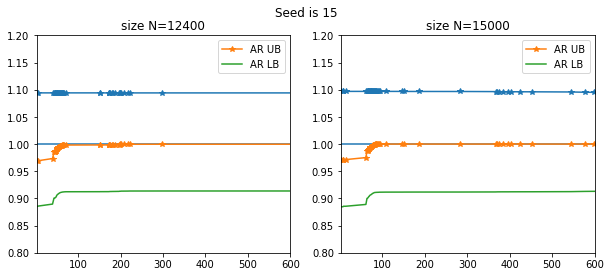

In [196]:
select_N = [12400, 15000]
select_p = 15
nfigs = len(select_N)

fig, axs = plt.subplots(1, nfigs, figsize=(5*nfigs, 4))
seed = 15
plt.suptitle(f'Seed is {seed}')
for i in range(nfigs):
    N = select_N[i]
    ax = axs[i] # only for single row layout
    plt.sca(ax)
    mh = to_mh(data_match.sel(seed=seed, N=N).data.item())
    AR = approx_ratio(select_p)
    print(f'N={N} Time to get AR bound {AR} for p={select_p} is {mh.get_time_for_AR_lower(AR)[0]}')
    mh.plot()
    plt.ylim(0.8, 1.20)
    plt.xlim(0, 600)
    plt.title(f'size N={N}')
    plt.xscale('linear')
    
    
    

### Times distributions over seeds for select N

N=9200 Median Time to get AR bound 0.8858630381154701 for p=12 is 9.106940627098083
len 50
N=10000 Median Time to get AR bound 0.8858630381154701 for p=12 is 7.653274774551392
len 50


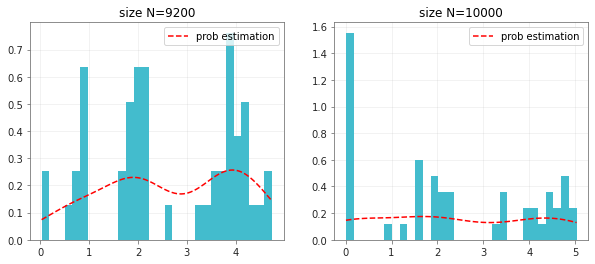

In [197]:
import scipy
select_N = [9200, 10000]
select_p = 12
nfigs = len(select_N)
plt.rcParams["axes.edgecolor"] = "0.45"
plt.rcParams["xtick.color"] = "0.45"
plt.rcParams["ytick.color"] = "0.45"
plt.rcParams["xtick.labelcolor"] = "0.15"
plt.rcParams["ytick.labelcolor"] = "0.15"


fig, axs = plt.subplots(1, nfigs, figsize=(5*nfigs, 4))
for i in range(nfigs):
    N = select_N[i]
    ax = axs[i] # only for single row layout
    plt.sca(ax)
    
    AR = approx_ratio(select_p)
    data_p = get_data_AR_lower(data_match.sel(N=N), AR)
    data_p = data_p.astype(np.float)
    data_p_clean = np.log(data_p[~np.isnan(data_p)])
    plt.hist(data_p_clean, bins=30, density=True, color='#43bccd', zorder=2)
    plt.grid(alpha=.2, zorder=0)
    print(f'N={N} Median Time to get AR bound {AR} for p={select_p} is {np.median(data_p)}')
    plt.title(f'size N={N}')
    
    # KDE
    kde = scipy.stats.gaussian_kde(data_p_clean)
    x = np.linspace(min(data_p_clean), max(data_p_clean), 100)
    print('len', len(data_p_clean))
    plt.plot(x, kde(x), '--', color='red', label='prob estimation')
    plt.legend(loc='upper right')
    
    
    

## Gap plot

In [198]:

data_match_mh = xar.apply_ufunc(to_mh, data_match, vectorize=True)
data_match_mh.N

<xarray.DataArray 'N' (N: 28)>
array([    30,    100,    150,    432,    716,   1000,   1400,   2600,   3800,
         5000,   5200,   6000,   6800,   7600,   8400,   9200,  10000,  10800,
        11600,  12400,  15000,  21250,  27500,  33750,  40000,  50000,  75000,
       100000])
Coordinates:
  * N        (N) int64 30 100 150 432 716 ... 33750 40000 50000 75000 100000

N=10000 best gap is 0.08398260796483745
N=12400 best gap is 0.08782690048671427
N=21250 best gap is 0.0935822076996185


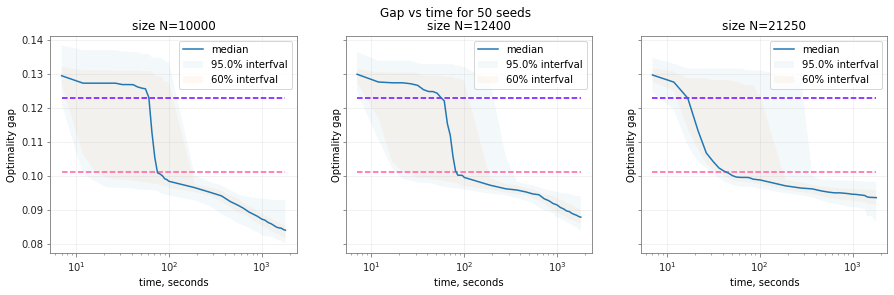

In [200]:

    

def plot_hist(select_N, get_val, data_match):
    nfigs = len(select_N)
    plt.rcParams["axes.edgecolor"] = "0.45"
    plt.rcParams["xtick.color"] = "0.45"
    plt.rcParams["ytick.color"] = "0.45"
    plt.rcParams["xtick.labelcolor"] = "0.15"
    plt.rcParams["ytick.labelcolor"] = "0.15"


    times = np.concatenate([
        np.linspace(7, 100, 20)
        ,np.linspace(100, 1800, 20)
    ])

    fig, axs = plt.subplots(1, nfigs, figsize=(5*nfigs, 4), sharey='row')
    for i in range(nfigs):
        N = select_N[i]
        try: 
            ax = axs[i] # only for single row layout
        except:
            ax = axs
        plt.sca(ax)

        gaps = []
        for ts in times:
            at_time = []
            for seed in data_match.seed:
                mh = data_match.sel(seed=seed, N=N).data.item()
                value = get_val(mh, ts)
                at_time.append(value)
            gaps.append(at_time)
            
        # debt
        """
        vals_rev = np.linspace(np.array(gaps).min(), np.array(gaps).max(), 30)
        times_rev = []
        for val in vals_rev:
            for_val = []
            for seed in data_match.seed:
                mh = data_match.sel(seed=seed, N=N).data.item()
                time_rev, ar = mh.get_time_for_AR_lower(val)
                if time_rev is None:
                    time_rev = np.inf
                for_val.append(time_rev)
            times_rev.append(for_val)
        select_AR = approx_ratio(p=18)
        for_val = []
        for seed in data_match.seed:
            mh = data_match.sel(seed=seed, N=N).data.item()
            time_rev, ar = mh.get_time_for_AR_lower(select_AR)
            if time_rev is None:
                time_rev = np.inf
            for_val.append(time_rev)
        print(f'N={N} time to get {select_AR} time = {np.median(for_val)}')
        
        av_tms = np.median(times_rev, -1)
        plt.plot(av_tms, vals_rev, '-*', label=f'rev median')
        """
                
        

        av = np.median(gaps, -1)
        plt.plot(times, av, '-', label=f'median')

        shift = 2.5
        up = np.percentile(gaps, 100-shift, axis=-1)
        dn = np.percentile(gaps, shift, axis=-1)
        plt.fill_between(times, dn, up, alpha=0.05, label=f'{100-2*shift}% interfval')

        shift = 20
        up = np.percentile(gaps, 100-shift, axis=-1)
        dn = np.percentile(gaps, shift, axis=-1)
        plt.fill_between(times, dn, up, alpha=0.05, label=f'{100-2*shift}% interfval')

        plt.grid(alpha=.2, zorder=0)
        print(f'N={N} best gap is {av[-1]}')
        plt.title(f'size N={N}')

        plt.legend()
        plt.xlabel('time, seconds')
        plt.ylabel('Optimality gap')
        plt.xscale('log')
        colors = get_colors(4)
        plt.hlines(0.101, xmin=min(times), xmax=max(times), linestyles='--', color=colors[2] )
        plt.hlines(0.123, xmin=min(times), xmax=max(times), linestyles='--', color=colors[1] )
    plt.suptitle(f'Gap vs time for {len(data_match.seed)} seeds')

    
    
select_N = [10000, 12400, 21250]
plot_hist(select_N, get_opt_gap, data_match_mh)


## AR vs time plot

N_sampl 20
p 14
0.8880920366031804
red q 6.40006
0.8880920366031804
av [0.88478848 0.88708118 0.88708118 0.88708118 0.88708118 0.88730704
 0.88740706 0.88743289 0.88769963 0.8881998  0.88839241 0.8904337
 0.8980058  0.9047741  0.90837554 0.90864535 0.90908177 0.90980327
 0.91000331 0.91041242 0.91041242 0.91197066 0.91312622 0.91399218
 0.91537895 0.91623388 0.91706106 0.91796284 0.91855039 0.9190796
 0.91971613 0.92002017 0.92059486 0.92090186 0.92133885 0.92174499
 0.92194341 0.92200565 0.92234513 0.92252403]
N=10000.0 best gap is 0.922524027608453
[0.0, 250.0, 500.0, 750.0, 1000.0, 1250.0, 1500.0, 1750.0]
N_sampl 20
p 14
0.8880920366031804
red q 13.487559999999998
0.8880920366031804
av [0.8848     0.88592941 0.88826492 0.89592157 0.90282353 0.9052549
 0.90633725 0.90785882 0.9083451  0.90887843 0.90938039 0.90944314
 0.90947451 0.90947451 0.9094902  0.90967276 0.90991231 0.90995655
 0.91003639 0.91006777 0.91006777 0.91152525 0.91207567 0.91227547
 0.91276042 0.91306258 0.91324674 0

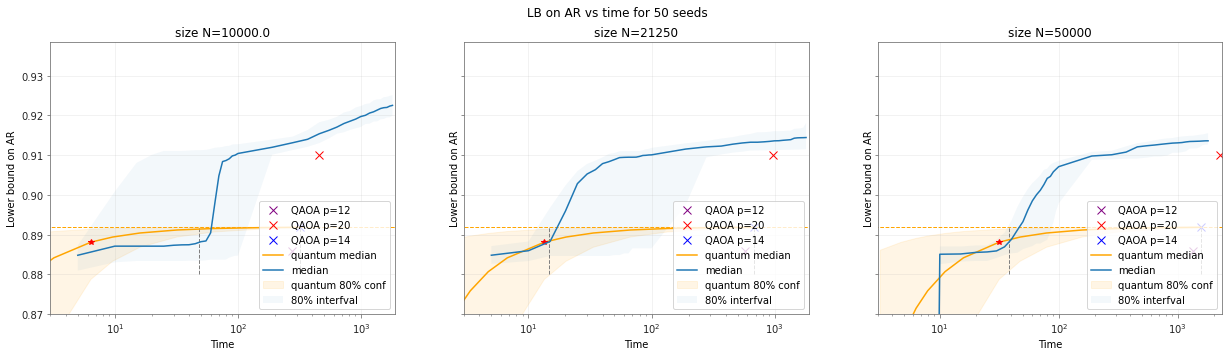

In [203]:
    
select_p = [12, 20, 14]
select_N = [1e4, 21250, 50000]

nfigs = len(select_N)

times = np.concatenate([
    np.linspace(5, 100, 20)
    , np.linspace(100, 1800, 20)
])

fig, axs = plt.subplots(1, nfigs, figsize=(7*nfigs, 5), sharey='row')
for i in range(nfigs):
    # -- Handle axes: case where 1 axis and many
    N = select_N[i]
    try: 
        ax = axs[i] # only for single row layout
    except:
        ax = axs
    plt.sca(ax)
    # --
    

    # -- Plot quantum guarantees for 1000 iterations
    colors=iter(['purple', 'red', 'blue'])
    for p in select_p:
        AR = approx_ratio(p)
        quants = quantum_data.sel(p=p, types='transport')
        time_q = quants[np.abs(quants.N - N).argmin()].data.item()
        plt.plot(time_q, AR, 'x', label=f'QAOA p={p}', color=next(colors), markersize=8)
    # --
        
    # -- Demonstrate special case for the _last_ p
    p = p
    time_q = time_q
    AR = approx_ratio(p)
    print('N_sampl', N_samples)
    print('p', p)
    
    q_reps = [2, 3, 4, 5, 7, 10, 20, 30, 50, 100, 200, 500, 1000]
    q_times = [time_q*x/1000 for x in q_reps]
    p_fail = 0.5
    ksi_min = [1-(1-AR)*(p_fail)**(-1/N) for N in q_reps]
    plt.plot(q_times, ksi_min, color='orange', label='quantum median')
    print(quantum_lower_bound(AR, N_samples, p_fail))
    plt.plot(time_q*N_samples/1000, quantum_lower_bound(AR, N_samples, p_fail), '*', color='red')
    print('red q', time_q/1000*N_samples)
    
    conf = 0.1
    ksi_min_low = [1-(1-AR)*(conf)**(-1/N) for N in q_reps]
    ksi_min_up = [1-(1-AR)*(1-conf)**(-1/N) for N in q_reps]
    plt.fill_between(q_times, ksi_min_low, ksi_min_up, alpha=0.1,
                     color='orange', label='quantum 80% conf')
    # --
    
    # -- calculate Classical match time
    times_ar = []
    AR_adj = quantum_lower_bound(AR, N_samples, p_fail)
    print(AR_adj)
    for seed in data_match_mh.seed:
        mh = data_match_mh.sel(seed=seed, N=N).data.item()
        t, _ = mh.get_time_for_AR_lower(AR_adj)
        if t is None:
            t=np.inf
        times_ar.append(t)
    time_g = np.median(times_ar)
    # --
    
    # depbt
    """
    ratios = np.linspace(.88, .92, 20)
    times_rat = []
    for ar in ratios:
        times_ar = []
        for seed in data_match_mh.seed:
            mh = data_match_mh.sel(seed=seed, N=N).data.item()
            t, _ = mh.get_time_for_AR_lower(ar)
            if t is None:
                t=np.inf
            times_ar.append(t)
        times_rat.append(times_ar)
    plt.plot(np.median(times_rat, -1), ratios, '*', color='black')
    """
    
    # -- Nice vertical lines
    plt.vlines(time_g, 0.88, AR, linestyle='--', color='gray', linewidth=1)
    plt.vlines(time_q, 0.88, AR, linestyle='--', color='gray', linewidth=1)
        
    
    # -- Handle gurobi match
    # ---- Calculate lower bound for various times
    gaps = []
    for ts in times:
        at_time = []
        for x in data_match_mh.sel(N=N):
            mh = x.item()
            value = get_lb(mh, ts)
            at_time.append(value)
        gaps.append(at_time)
    # ----
    
    gaps = np.array(gaps).astype(np.float)
    av = np.nanmedian(gaps, -1)
    print('av', av)
    plt.plot(times, av, '-', label=f'median')


    shift = 10
    up = np.percentile(gaps, 100-shift, axis=-1)
    dn = np.percentile(gaps, shift, axis=-1)
    plt.fill_between(times, dn, up, alpha=0.05, label=f'{100-2*shift}% interfval')
    # --

    plt.grid(alpha=.2, zorder=0)
    print(f'N={N} best gap is {av[-1]}')
    plt.title(f'size N={N}')
    
    
    # -- Ticks prettify
    num_ticks = list(plt.gca().get_xticks())[1:-1]
    print(num_ticks)
    ticks = num_ticks + [time_g, time_q]
    def get_label(x):
        if x>60*60:
            return f'{round(x/60/60)} h'
        if x>60:
            return f'{round(x/60)} min'
        elif x>1:
            return f'{round(x)} s'
        elif x>0.001:
            return f'{round(x*1000)} ms'
    
    num_labels = [get_label(x) if x!=0 else '0' for x in num_ticks]
    labels = num_labels + [r'$\tau_C$', r'$\tau_Q$']
    plt.xticks(ticks=ticks, labels=labels)
    ticks_large = plt.xticks()[-1][-2:]
    for tick in ticks_large:
        tick.set_fontsize(14)
    # --
    
    ylim = plt.gca().get_ylim()
    
    xlim = plt.gca().get_xlim()
    plt.xscale('log')
    plt.hlines(AR, xlim[0], xlim[1], linestyle='--', color='orange', linewidth=1)
    
    plt.xlim(*[3, max(*xlim)])
    plt.ylim(0.87, ylim[1]*1.0)

    plt.legend(loc='lower right')
    plt.xlabel('Time')
    plt.ylabel('Lower bound on AR')
plt.suptitle(f'LB on AR vs time for {len(data_match_mh.seed)} seeds')
plt.savefig(f'./pdf/bound_vs_time_N{N}.pdf')

In [ ]:
d = []
for N in data_match.N[3:]:
    at_N = []
    for seed in data_match_mh.seed:
        mh = data_match_mh.sel(seed=seed, N=N).data.item()
        ub, lb = mh.get_bounds_at(500)
        gap = (ub-lb)/lb
        at_N.append(gap)
    d.append(at_N)
    
m = np.median(d, -1)
plt.vlines(7600, min(m), max(m), linestyles='--')
plt.vlines(12400, min(m), max(m), linestyles='--')
plt.plot(data_match.N[3:], m, '*-')
plt.xscale('log')
plt.grid(alpha=.1)
plt.title('Median gap after 500 seconds')
plt.xlabel('Size N')
plt.ylabel('gap')


## 3-d plot AR vs N vs time

In [ ]:
times = np.concatenate([
    np.linspace(5, 100, 30),
    np.linspace(100, 1800, 30)
])

space = []
for N in data_match_mh.N:
    gaps = []
    for ts in times:
        at_time = []
        for x in data_match_mh.sel(N=N):
            mh = x.item()
            value = get_lb(mh, ts)
            at_time.append(value)
        v = np.nanmedian(np.array(at_time).astype(np.float))
        if v == 0.:
            v = np.nan
        gaps.append(v)
    space.append(gaps)


In [ ]:
space_q = []
p = 14
AR = approx_ratio(p)
for N in quantum_data.N:
    gaps = []
    for ts in times:
        t_q = quantum_data.sel(N=N, p=p, types='transport')
        N_s = int(ts/(t_q/1000))
        ar = quantum_lower_bound(AR, N_s, conf=.5)
        gaps.append(ar)
    space_q.append(gaps)
    

In [ ]:
space_m = np.zeros((len(space_q), len(times)))
sup_min = []
sup_max = []

for n in range(len(space)):
    q = np.array(space_q[n])
    c = np.array(space[n])
    ixs = np.where((q-c)>0)[0]
    if len(ixs) == 0:
        sup_min.append(None)
        sup_max.append(None)
        continue
    sup_min.append(times[min(ixs)])
    sup_max.append(times[max(ixs)])
    

In [ ]:

fig = plt.figure(figsize=(12, 7))
plt.contourf(data_match_mh.N, times, np.array(space).T, levels=25)
plt.xscale('log')
plt.yscale('log')
clb = plt.colorbar()
clb.ax.set_title('AR bound',fontsize=12)

plt.fill_between(data_match_mh.N,
                 np.array(sup_min).astype(np.float),
                 np.array(sup_max).astype(np.float),
                 alpha=.8,
                 color='green',
                 label='Supremacy area, p=14'
                )
#plt.plot(data_match_mh.N, sup_min)
#plt.plot(data_match_mh.N, sup_max)
plt.legend()
plt.xlabel('N')
plt.ylabel('Solver time, s')

In [ ]:
space

In [ ]:
times

In [ ]:
{'Symmetry': 0, 'PreQLinearize': 2}

In [ ]:

ax = plt.gca()
ax.get_ylim()


In [ ]:
plt.gcf().axes



In [ ]:
1/1.068

When we run algorithm on a large graph, we don't know the optimal cost, only the cost value obtained so far.

But what we want to know is approximation ratio. 

We con get a lower bound on approximation ratio

$$
R_l = \frac{Z_l}{Z_u} = 1/(G+1)
$$
    
One of useful measures of quality of solution obtained so far is band gap - relative difference between upper and lower bound. 

If upper bound is $Z_u$ and lower bound is $Z_l$ then the gap is

$$
G = |Z_u -  Z_l|/Z_l = 1/R_l - 1
$$



1

TODO:
    1. Plot first result of gurobi cut freq vs N
    2. Plot first result of gurobi time vs N
    3. Plot cut fraction vs time for gurobi
    4. For different degrees
    5. Count number of trees